# Objective

Cluster job postings by job requirements to identify most preferred/required skills for data scientist and other adjacent roles.

In [1]:
from pathlib import Path
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.rc('font', size = 12)

curpath = Path.cwd()
datapath = curpath.joinpath('output/top100_most_similar.csv')
df = pd.read_csv(datapath)

In [2]:
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100 entries, 0 to 99
Data columns (total 6 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   html                         100 non-null    object 
 1   position                     100 non-null    object 
 2   location                     100 non-null    object 
 3   company                      15 non-null     object 
 4   jobreq                       100 non-null    object 
 5   cosine_similarity_to_resume  100 non-null    float64
dtypes: float64(1), object(5)
memory usage: 4.8+ KB
None


In [3]:
import pickle
with open('output/corpus_results.pickle', 'rb') as input:
    csr_matrix = pickle.load(input)
    features = pickle.load(input)
    params = pickle.load(input)
    print(params)

{'analyzer': 'word', 'binary': False, 'decode_error': 'strict', 'dtype': <class 'numpy.float64'>, 'encoding': 'utf-8', 'input': 'content', 'lowercase': True, 'max_df': 0.8, 'max_features': None, 'min_df': 4, 'ngram_range': (1, 2), 'norm': 'l2', 'preprocessor': None, 'smooth_idf': True, 'stop_words': 'english', 'strip_accents': None, 'sublinear_tf': False, 'token_pattern': '(?u)\\b\\w\\w+\\b', 'tokenizer': None, 'use_idf': True, 'vocabulary': None}


# Stem and count words in job postings.

1. Stem words in the job posting texts with `nltk.stem.snowball.SnowballStemmer`.
2. Run `sklearn.TfidfVectorizer` on the stemmed data, which now consists of the top 100 most similar job postings.


In [4]:
from nltk.stem.snowball import SnowballStemmer
from nltk.tokenize import MWETokenizer, word_tokenize

mwe_tokenizer = MWETokenizer([('machine', 'learning'),
                              ('natural', 'language', 'processing'),
                  ('data', 'science'), ("Bachelor", "'s"), ("Master", "'s"),
                  ('work', 'experience'), ('computer', 'science'),
                ('artificial', 'intelligence'), 
                              ('deep', 'learning'), ('naive', 'bayes'), ('big', 'data'),
                             ('communication', 'skill'), ('problem', 'solving'), ('state', 'of', 'the', 'art')])

stemmed_data = [" ".join([SnowballStemmer("english", ignore_stopwords = True).stem(token) 
    for token in mwe_tokenizer.tokenize([word for word in word_tokenize(text.lower())])]) for text in df['jobreq'] ]
non_stemmed_data = [" ".join([token for token in 
                              mwe_tokenizer.tokenize([word for word in word_tokenize(text.lower())])]) 
                    for text in df['jobreq'] ]

In [5]:
from sklearn.feature_extraction.text import TfidfVectorizer

vectorizer = TfidfVectorizer(**params)
csr_matrix = vectorizer.fit_transform(non_stemmed_data)
np_matrix = csr_matrix.toarray()
matrix_centered = np_matrix - np.mean(np_matrix, axis = 0)
words = vectorizer.get_feature_names()
print("{} posts and {} features".format(*matrix_centered.shape))

100 posts and 1181 features


# Reduce matrix dimension

1. Run SVD on `np_matrix`. 
2. Plot the singular values from $k = 1$ to $k = r$ where $r$ is the rank of `np_matrix` and the relative error of rank $k$ approximation. 
3. Use the plots to choose the number of components. 


In [6]:
r = np.linalg.matrix_rank(matrix_centered)
print("The original {}-by-{} matrix has rank {}".format(*matrix_centered.shape, r))

The original 100-by-1181 matrix has rank 96


In [7]:
u, s, vt = np.linalg.svd(matrix_centered, full_matrices = False)
pd.DataFrame(vt, columns = words).head()

,10,2019,24,24 week,30am,30am 30pm,30pm,30pm includes,abilities,ability,...,writing,written,written communication,written verbal,xgboost,year,years,years experience,years industry,years relevant
0,0.010834,-0.003581,0.062328,0.065544,0.065544,0.065544,0.082496,0.082496,-0.003908,-0.036324,...,-0.006625,-0.012451,-0.007403,-0.005288,-0.006280,0.009711,-0.017724,-0.024122,-0.005973,-0.005137
1,-0.030592,-0.032074,0.000069,0.002933,0.002933,0.002933,0.003869,0.003869,-0.012234,0.028530,...,-0.030867,0.016749,0.018436,-0.002886,0.002623,-0.007902,-0.063601,-0.106916,0.003761,0.012345
2,0.012310,0.011781,0.000144,0.000310,0.000310,0.000310,0.000543,0.000543,-0.009657,-0.067660,...,-0.032459,-0.027508,-0.010221,-0.024078,0.008303,-0.002837,-0.048547,-0.054032,-0.003441,-0.006136
3,0.026867,0.033617,-0.001654,-0.003671,-0.003671,-0.003671,-0.004803,-0.004803,0.006686,-0.003518,...,-0.003743,-0.004245,-0.007164,0.001392,0.004997,-0.008236,-0.026188,-0.010642,-0.008299,0.015659
4,0.017231,0.038336,-0.006085,-0.005606,-0.005606,-0.005606,-0.006373,-0.006373,0.013503,0.018846,...,-0.005471,0.033362,0.031432,0.012178,-0.033924,0.031641,-0.001525,-0.004139,-0.018047,-0.005795


In [8]:
print(vt.shape)

(100, 1181)


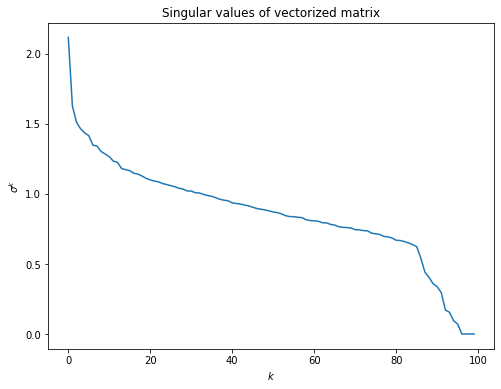

In [9]:
import matplotlib.pyplot as plt

plt.figure(figsize = (8, 6))
plt.plot(s)
plt.title("Singular values of vectorized matrix")
plt.ylabel(r"$\sigma^k$")
plt.xlabel(r"$k$")
plt.show()

$\sigma_k$ is the $k$th element in the diagonal matrix $\Sigma$ from the SVD decomposition of the original matrix. We want to select $k$ that gives the best rank-$k$ approximation of the original matrix. According to the plot above, the singular values steeply decrease around $k=5$ and then has another steep decrease around $k=80$.

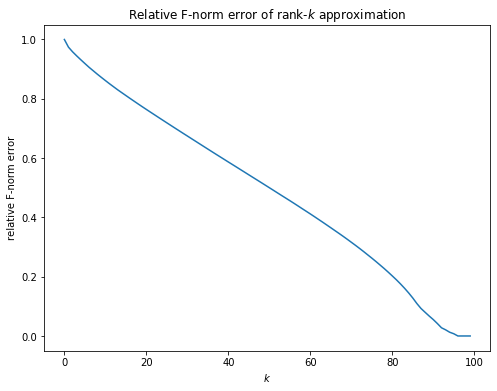

In [10]:
norm = np.linalg.norm(matrix_centered)
err = np.sqrt(np.cumsum(s[::-1]**2)[::-1])

plt.figure(figsize = (8, 6))
plt.title("Relative F-norm error of rank-$k$ approximation")
plt.plot(err/norm)
plt.xlabel(r"$k$")
plt.ylabel("relative F-norm error")
plt.show()

The figure above plots $\dfrac{\|A^{(k)}- A\|_F}{\|A\|_F}$ from $k= 1$ to $k= 100$. There is a steep decrease around $k=5$ and another one around $k=85$, which parallele what we saw in the singular values plot. However, only past $k=85$ do we reduce the approximation error below 10%. 

In [11]:
pd.Series(err[75:]/norm, index =[i for i in range(75, 100)])

75    2.626201e-01
76    2.512499e-01
77    2.395059e-01
78    2.276709e-01
79    2.152874e-01
80    2.024994e-01
81    1.894666e-01
82    1.755575e-01
83    1.607820e-01
84    1.450317e-01
85    1.280177e-01
86    1.093204e-01
87    9.278957e-02
88    7.988802e-02
89    6.723536e-02
90    5.525800e-02
91    4.188595e-02
92    2.762968e-02
93    2.076874e-02
94    1.258194e-02
95    7.501378e-03
96    1.138935e-16
97    5.373001e-17
98    2.504676e-17
99    1.628230e-17
dtype: float64

In [18]:
k = 80
matrix_approx = u[:, :k] @ np.diag(s[:k])
print("Rank-{} approximation of the original matrix is {} by {}.".format(k, *matrix_approx.shape))

Rank-80 approximation of the original matrix is 100 by 80.


# k-means clustering

1. Implement `sklearn.KMeans` clustering on the approximated matrix we produced in the previous step.
2. Evaluate the number of clusters that best group the data by plotting the [silhouette scores](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.silhouette_score.html) and inertia.
3. Visualize clusters with word clouds.

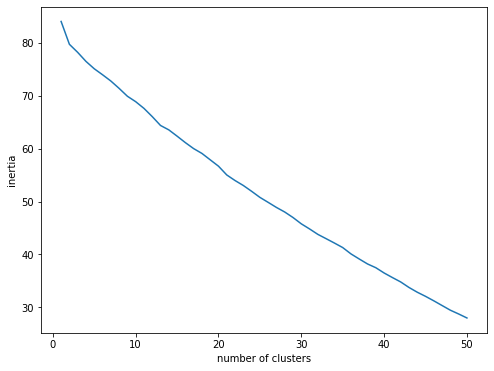

In [19]:
from sklearn.cluster import KMeans
import sklearn.metrics as metrics



def evaluate_clusters(X, max_clusters):
    error = []
    for n in range(1, max_clusters + 1):
        kmeans = KMeans(init = "k-means++", n_clusters = n, n_init = 10, random_state = 402)
        kmeans.fit_predict(X)
        error.append(kmeans.inertia_)
    
    plt.figure(figsize = (8, 6))
    plt.plot(range(1, max_clusters + 1), error)
    plt.xlabel("number of clusters")
    plt.ylabel("inertia")

evaluate_clusters(matrix_approx, max_clusters = 50)
    

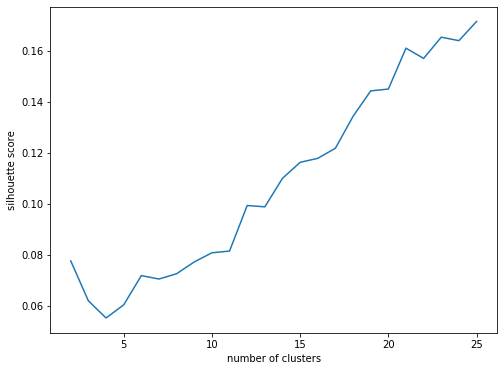

In [22]:
def sscore_evaluate_clusters(X, max_clusters):
    sscore = []
    for n in range(2, max_clusters + 1):
        kmeans = KMeans(init = "k-means++", n_clusters = n, n_init = 100, random_state = 100)
        kmeans.fit_predict(X)
        sscore.append(metrics.silhouette_score(X, kmeans.labels_, metric = "cosine"))
    
    plt.figure(figsize = (8, 6))
    plt.plot(range(2, max_clusters + 1), sscore)
    plt.xlabel("number of clusters")
    plt.ylabel("silhouette score")

sscore_evaluate_clusters(matrix_approx, max_clusters = 25)

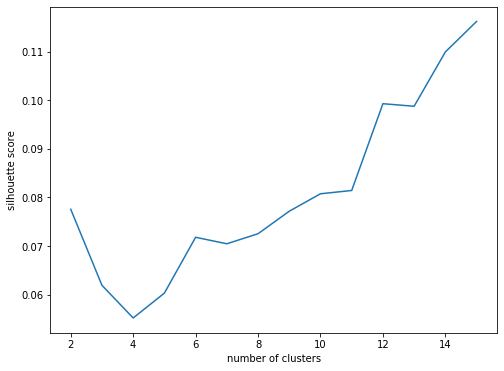

In [23]:
sscore_evaluate_clusters(matrix_approx, max_clusters = 15)

The first plot of inertia, which is the sum of squared distance of each point to its cluster center and measures the internal coherence of clusters, tells us nothing other than that the amount of error decreases as we increase the number of clusters, which is to be expected. The second plot says that the silhouette score has local maximum at $n=2$ and $n=5$, and then keeps increasing after $n=8$. 

# Visualize clusters

1. Cluster the approximated matrix into $n=5$ clusters. 
2. Print the top 5 words used in each cluster according to their total tf-idf.

In [24]:
n = 10
kmeans = KMeans(init = "k-means++", n_clusters = n, n_init = 100, random_state = 100)
kmeans.fit_predict(matrix_approx)
labels = pd.Series(kmeans.labels_)
labels.groupby(labels).size()

0    15
1     5
2    17
3     7
4    10
5    13
6     5
7    22
8     2
9     4
dtype: int64

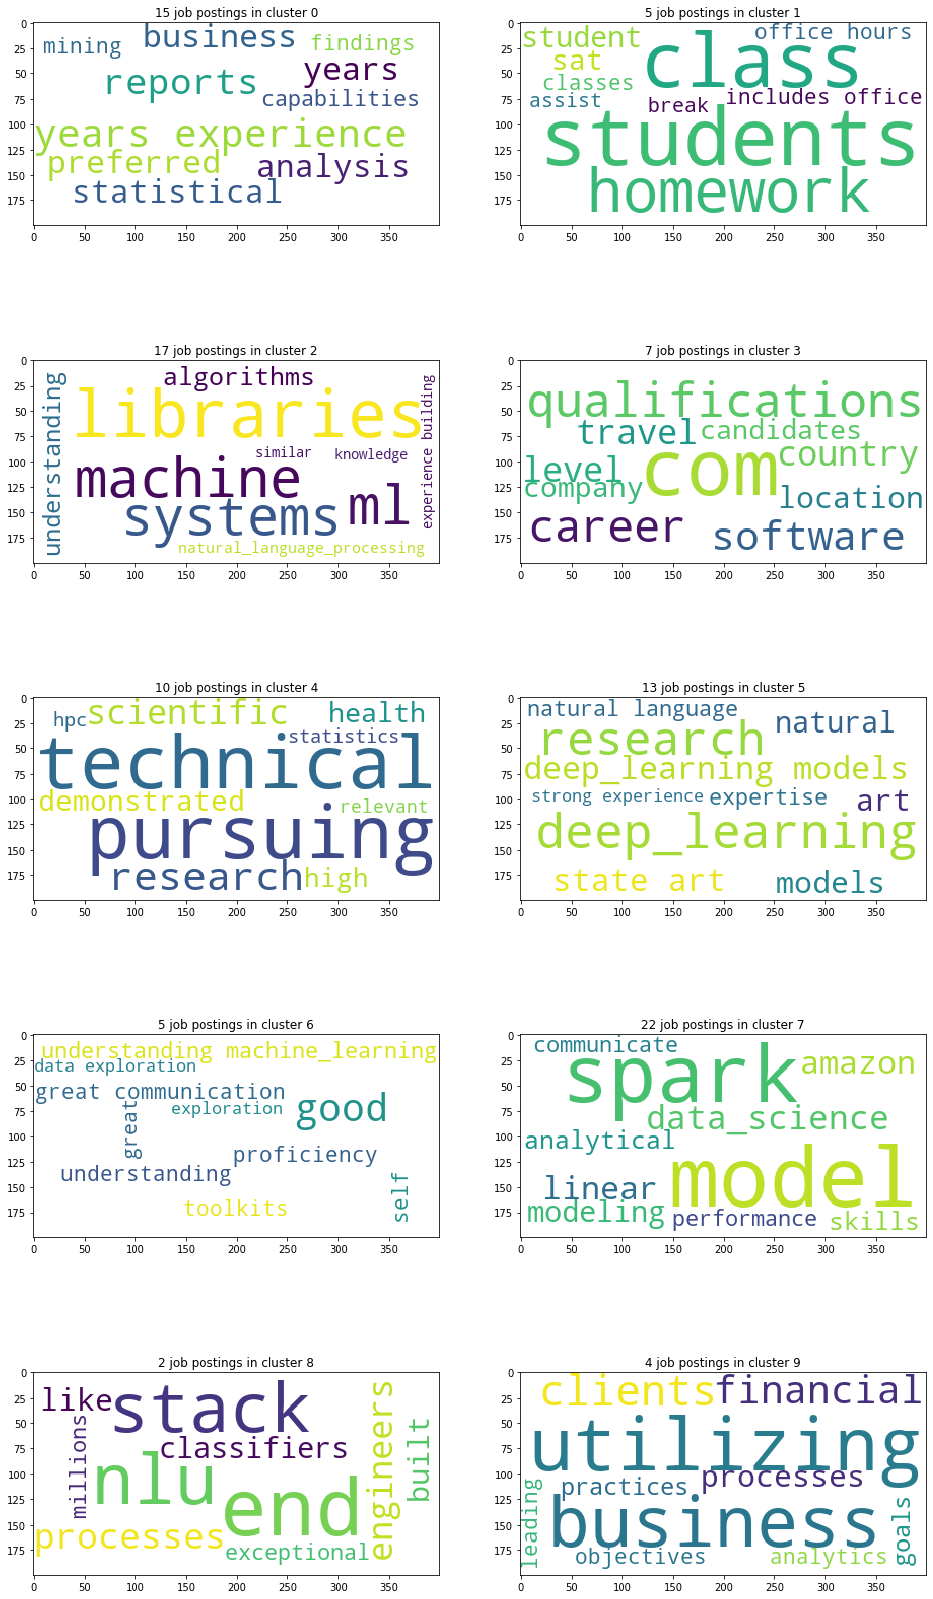

In [38]:
from wordcloud import WordCloud
cloud_generator = WordCloud(random_state = 123, max_words = 10, background_color = "white")

clustered = labels.groupby(labels)

figure, axes = plt.subplots(5, 2, figsize=(16, 30))
axes = axes.flatten()


def cluster_words(indice, name):
    sum_tfidf = pd.Series(matrix_centered[indice].sum(axis = 0), index = words).sort_values(ascending = False)
    wordcloud = cloud_generator.fit_words(sum_tfidf)
    
    axes[name].imshow(wordcloud)
    axes[name].set_title(f"{len(clustered.get_group(name))} job postings in Cluster {name}")
    


for name, group in clustered:
    cluster_words(group.index, name)

I have clustered the job postings into 10 clusters and visualized the most frequent terms as word clouds. Some clusters seem more tight and well-defined than others. For instance, the five job postings that ended up in Cluster 1 seem to be for an instructor position teaching data science. The ten job postings put in Cluster 4 look like they are related to hospital data analyst positions. On the other hand, Clusters 3, 6, and 8 look more loose and generic. 

In [41]:
def get_job_titles(indice, name):
    print(name, df.position[indice].values)

for name, group in clustered:
    get_job_titles(group.index, name)

0 ['data analyst' 'natural language processing data scientist- audit'
 'data analyst and data scientist' 'workforce development data analyst'
 'data scientist/ machine learning engineer' 'lead data scientist'
 'senior data scientist' 'senior data analyst' 'data scientist'
 'data scientist' 'senior data scientist' 'data scientist'
 'lead data scientist'
 'people research scientist, internal communications' 'data scientist']
1 ['data analytics teaching assistant' 'entry-level data analysts'
 'data analytics instructor, ut austin' 'data analytics instructor'
 'data analytics instructor- washington university, st. louis']
2 ['machine learning postdoctoral fellow' 'data/nlp scientist'
 'natural language processing and machine learning scientist'
 'data architect'
 'machine learning engineer : natural language processing'
 'natural language processing and machine learning engineer'
 'data scientist' 'data scientist' 'machine learning engineer'
 'data engineer' 'data scientist iii' 'data scie

Looking at the job titles in each cluster, I believe that my clustering worked pretty well. Cluster 1 consists of instructor positions that would plausibly generate the word cloud we plotted above. But the clustering didn't work well for other job postings such as Cluster 8. Even though Cluster 8's job postings are both for senior NLP engineer, the word cloud they generated do not connote high experience level. It turns out that this is because these two job postings are for identical positions. 